# Understanding and Predicting Property Maintenance Fines

This project is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 
___

Create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

# Import the python libraries

In [750]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import graphviz
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz

# Helper Functions

## Datasets

In [400]:
def prepare_train_dataset(file, columns):
    df_train = pd.read_csv(file, encoding='ISO-8859-1', low_memory=False)
    df_train = df_train[(df['city'].str.lower() == 'detroit') & (~df_train['compliance_detail'].str.contains('not responsible')) & (~df['compliance_detail'].str.contains('compliant by no fine'))].set_index('ticket_id')
    X = df_train[columns]
    y = df_train['compliance']

    return X,y

In [401]:
def prepare_test_dataset(file, columns):
    df_test = pd.read_csv(file, encoding='ISO-8859-1', low_memory=False)
    df_test = df_test.fillna(0).set_index('ticket_id')
    X_pred = df_test[columns]

    return X_pred

In [402]:
def transform(le, data_list):
    """
    This will transform the data_list to id list where the new values get assigned to Unknown class
    :param data_list:
    :return:
    """
    new_data_list = list(data_list)
    for unique_item in np.unique(data_list):
        if unique_item not in le.classes_:
            new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

    return le.transform(new_data_list)

## Plots

In [663]:
def define_percentage_compliance(df, field):
    compliance={}
    compliance_values = [0,1]
    for value in compliance_values:
        compliance[value] = []
    total_people = df[field].count()

    compliance[1] = df[df['compliance'] == 1][field].value_counts()
    compliance[0] = df[df['compliance'] == 0][field].value_counts()
    
    return compliance

In [640]:
def define_percentage_compliance_folds(df, field, compliance_field='compliance', compliance_values=[0,1], folds=[50, 100, 150, 200, 250, 300, 350, 'rest']):
    compliance={}
    for value in compliance_values:
        compliance[value] = []
        
    total_people = df[field].count()
    
    for i in range(len(folds)):
        if folds[i] == 'rest':
            for value in compliance_values:
                compliance[value].append(df[(df[field] > folds[i-1]) & (df[compliance_field] == value)][field].count())
        elif i == 0:
            for value in compliance_values:
                compliance[value].append(df[(df[field] <= folds[i]) & (df[compliance_field] == value)][field].count())
        else:
            for value in compliance_values:
                compliance[value].append(df[(df[field] > folds[i-1]) & (df[field] <= folds[i]) & (df[compliance_field] == value)][field].count())

    for key, values in compliance.items():
        compliance[key] = [element/total_people for element in values]
    
    return compliance

In [770]:
def plot_percent_compliance_bar_folds_chart(y, w=10, folds=[50, 100, 150, 200, 250, 300, 350, 400], folds_ticks=['0~50', '50~100', '100~150', '150~200', '200~250', '250~300', '300~350', '>350'], legend=['Compliant', 'Not Compliant']):
    plt.figure(figsize=(12,6))
    ax = plt.subplot(111)
    ax.bar([element - w/2 for element in folds], y[1], width=w) 
    ax.bar([element + w/2 for element in folds], y[0], width=w) 
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.xticks(folds, folds_ticks)
    plt.legend(legend, loc='best', framealpha=0.0)
    plt.show()

In [783]:
def plot_percent_compliance_bar_chart(field, xlim=(), ylim=(), legend=['Compliant', 'Not Compliant']):
    compliance = define_percentage_compliance(df, field)
    plt.figure(figsize=(12,6))
    ax = plt.subplot()
    w = 1
    ax.bar([element - w/2 for element in list(compliance[1].index)], compliance[1].apply(lambda x: x/total_people), width=w) 
    ax.bar([element + w/2 for element in list(compliance[0].index)], compliance[0].apply(lambda x: x/total_people), width=w)

    
    if len(xlim) > 0:
        plt.xlim(xlim[0], xlim[1])
    
    if len(ylim) > 0:
        plt.ylim(ylim[0], ylim[1])
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.legend(legend, loc='best', framealpha=0.0)
    plt.show()

In [680]:
def plot_percent_compliance_scatter_chart(field, xlim=(), ylim=(), legend=['Compliant', 'Not Compliant']):
    compliance = define_percentage_compliance(df, field)
    plt.figure(figsize=(12,6))
    ax = plt.subplot(111)
    ax.scatter(compliance[1].index, compliance[1].apply(lambda x: x/total_people), marker='o') 
    ax.scatter(compliance[0].index, compliance[0].apply(lambda x: x/total_people), marker='o')
    
    if len(xlim) > 0:
        plt.xlim(xlim[0], xlim[1])
    
    if len(ylim) > 0:
        plt.ylim(ylim[0], ylim[1])
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.legend(legend, loc='best', framealpha=0.0)
    plt.show()

In [720]:
def plot_compliance_scatter_features_chart(df, x, y, colors = ['#FF7F0E', '#1F77B4'], xticks=[], yticks=[], xlim=(), ylim=(), legend=['Not Compliant', 'Compliant']):
    plt.figure(figsize=(12,6))
    ax = plt.subplot(111)
    ax.scatter(df[x], df[y], c=df['compliance'], cmap=ListedColormap(colors), marker='o') 
    
    if len(xticks) > 0:
        x_interval=[]
        for i in range(len(xticks)):
            x_interval.append(i)
        plt.xticks(x_interval, xticks)
    
    if len(yticks) > 0:
        y_interval=[]
        for i in range(len(yticks)):
            y_interval.append(i)
        plt.yticks(y_interval, yticks)
        
    if len(xlim) > 0:
        plt.xlim(xlim[0], xlim[1])
    
    if len(ylim) > 0:
        plt.ylim(ylim[0], ylim[1])
    
    legend_handles = []
    for i in range(0, len(legend)):
        patch = mpatches.Patch(color=colors[i], label=legend[i])
        legend_handles.append(patch)
    ax.legend(loc=0, handles=legend_handles, framealpha=0.0)
    
    plt.show()

# Features information

In [467]:
df = pd.read_csv('csv/train.csv', encoding='ISO-8859-1', low_memory=False)
df['city'].unique()

array(['CHICAGO', 'Detroit', 'DETROIT', ..., 'highland', 'harbor',
       'DERABORN'], dtype=object)

For executing the describe() command, first I removed all entries that are not from Detroit and the person was not fined (considered not responsible or compliant by no fine)

In [468]:
df = df[(df['city'].str.lower() == 'detroit') & (~df['compliance_detail'].str.contains('not responsible')) & (~df['compliance_detail'].str.contains('compliant by no fine'))].set_index('ticket_id')
df.describe()

,violation_street_number,violation_zip_code,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance
count,9.586500e+04,0.0,9.516800e+04,95865.000000,95865.0,95865.0,95865.000000,95865.000000,95865.0,95865.000000,95865.000000,95865.000000,95865.000000
mean,1.029785e+04,NaN,7.873750e+03,324.560789,20.0,10.0,30.632728,0.158170,0.0,385.193517,57.551083,327.484348,0.069953
std,4.647504e+04,NaN,2.305454e+04,599.643509,0.0,0.0,60.198046,2.905758,0.0,659.207965,166.379413,664.317336,0.255068
min,0.000000e+00,NaN,1.000000e+00,25.000000,20.0,10.0,0.000000,0.000000,0.0,55.000000,0.000000,-3280.000000,0.000000
25%,4.309000e+03,NaN,8.310000e+02,200.000000,20.0,10.0,10.000000,0.000000,0.0,250.000000,0.000000,85.000000,0.000000
50%,9.501000e+03,NaN,2.661000e+03,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000
75%,1.539700e+04,NaN,1.354100e+04,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000
max,1.415411e+07,NaN,3.511219e+06,10000.000000,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,11030.000000,11030.000000,1.000000


Analysing the report above and the variable descriptions given, I decided to use the judgement_amount value to train the model.
Since the mean value of the judgement_amount column is 385.2, 75% of the values are lower than 305 and the standard deviation is 659.2, we can infer that there are a lot of outliers in this column.
First, I plotted the chart below to have an overview of the distribution of the column values.

## judgment_amount

Bar plot with interval percentages

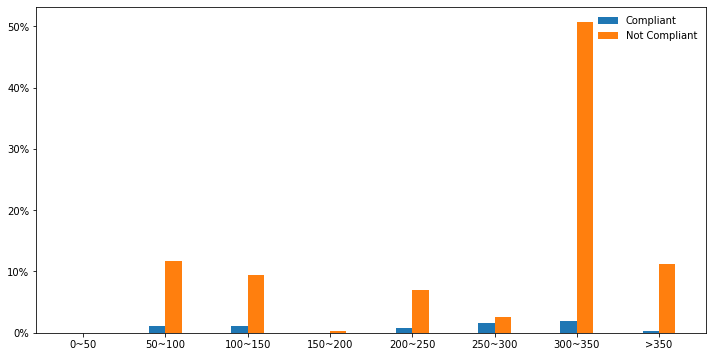

In [771]:
compliance_sizes = define_percentage_compliance_folds(df, 'judgment_amount')
plot_percent_compliance_bar_folds_chart(compliance_sizes)

Scatter plot with percentage value of each exact amount

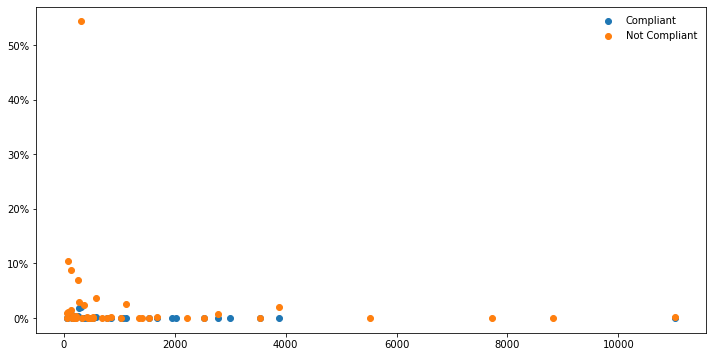

In [772]:
plot_percent_compliance_scatter_chart('judgment_amount')

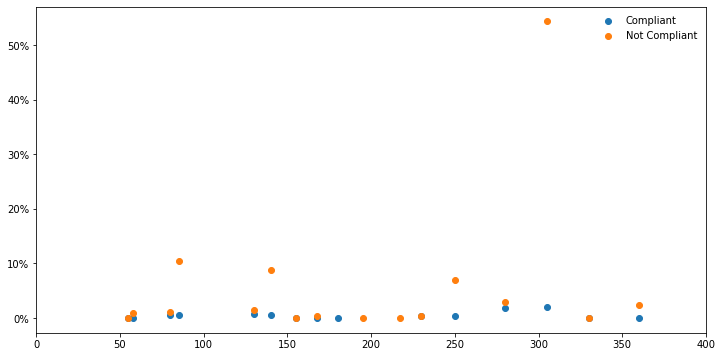

In [773]:
plot_percent_compliance_scatter_chart('judgment_amount', xlim=(0,400))

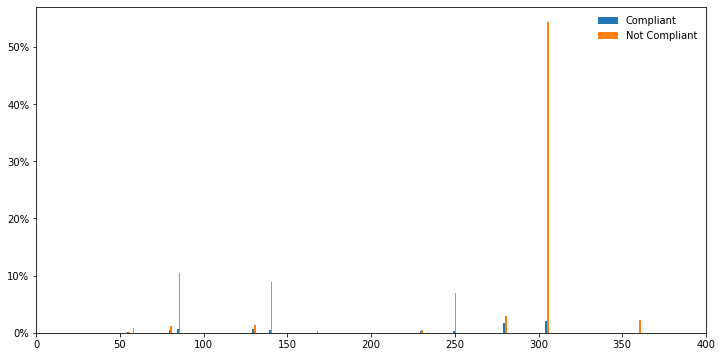

In [784]:
plot_percent_compliance_bar_chart('judgment_amount', xlim=(0,400))

## disposition

Plot the scatter chart to visualize the distribution of compliant and not compliant entries by disposition

In [775]:
df['disposition'].unique()

array(['Responsible by Determination', 'Responsible by Default',
       'Responsible by Admission'], dtype=object)

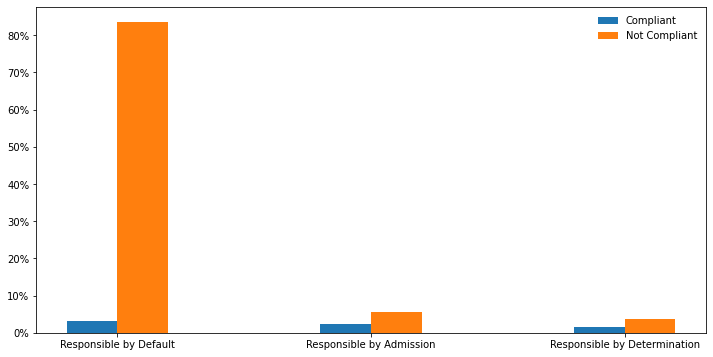

In [776]:
total_people = df['disposition'].count()
compliance_sizes={}
compliance_sizes[1] = df[df['compliance'] == 1]['disposition'].value_counts().apply(lambda x: x/total_people)
compliance_sizes[0] = df[df['compliance'] == 0]['disposition'].value_counts().apply(lambda x: x/total_people)
plot_percent_compliance_bar_folds_chart(compliance_sizes, folds=[50, 100, 150], folds_ticks=compliance_sizes[0].index)

Distribution of compliant and not compliant entries using both features

In [777]:
df['disposition'].unique()

array(['Responsible by Determination', 'Responsible by Default',
       'Responsible by Admission'], dtype=object)

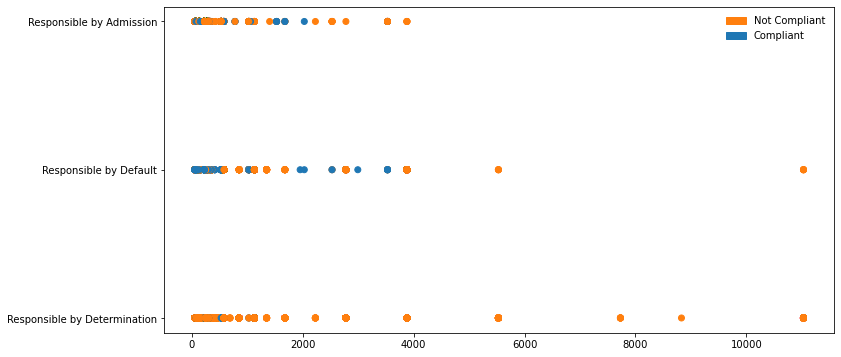

In [778]:
plot_compliance_scatter_features_chart(df, 'judgment_amount', 'disposition_category', yticks=df['disposition'].unique())

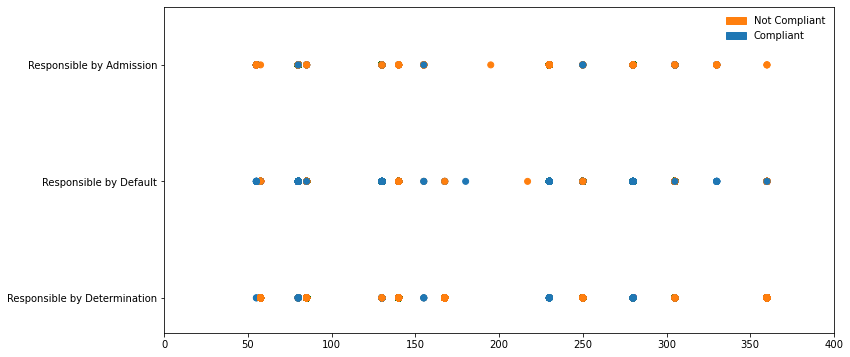

In [779]:
plot_compliance_scatter_features_chart(df, 'judgment_amount', 'disposition_category', yticks=df['disposition'].unique(), xlim=(0,400), ylim=(-0.3,2.5))

## violations

In [780]:
total_people = df['violation_code'].value_counts().where(lambda x: x > 1000).dropna().sum()

total_compliant_people = df[df['compliance'] == 1]['violation_code'].value_counts().where(lambda x: x > 1000).dropna()
total_non_compliant_people = df[df['compliance'] == 0]['violation_code'].value_counts().where(lambda x: x > 1000).dropna()
print(total_people)
total_compliant_people

89399.0


9-1-36(a)    3022.0
Name: violation_code, dtype: float64

## Dummy Classifier

In [781]:
def blight_dummy_model():
    from sklearn.dummy import DummyClassifier

    # Prepare the datasets
    columns = ['judgment_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    clf = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:,1]

    # Calculate the probability of test.csv rows
    print('Cross-validation accuracy: ', np.mean(cross_val_score(DummyClassifier(strategy = 'most_frequent'), X, y)))
    print('Cross-validation precision: ', np.mean(cross_val_score(DummyClassifier(strategy = 'most_frequent'), X, y, scoring='precision')))
    print('Cross-validation recall: ', np.mean(cross_val_score(DummyClassifier(strategy = 'most_frequent'), X, y, scoring='recall')))
    print('Cross-validation f1: ', np.mean(cross_val_score(DummyClassifier(strategy = 'most_frequent'), X, y, scoring='f1')))
    print('Cross-validation AUC: ', np.mean(cross_val_score(DummyClassifier(strategy = 'most_frequent'), X, y, scoring='roc_auc')))

In [752]:
blight_dummy_model()

Cross-validation accuracy:  0.9302223038765387
Cross-validation precision:  0.0
Cross-validation recall:  0.0
Cross-validation f1:  0.0
Cross-validation AUC:  0.5


<ipython-input-400-370c4fd3a513>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df_train[(df['city'].str.lower() == 'detroit') & (~df_train['compliance_detail'].str.contains('not responsible')) & (~df['compliance_detail'].str.contains('compliant by no fine'))].set_index('ticket_id')
C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression

In [753]:
def blight_logistic_model():
    from sklearn.linear_model import LogisticRegression

    # Prepare the datasets
    columns = ['judgment_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    clf = LogisticRegression().fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:,1]

    # Calculate the probability of test.csv rows
    print('Cross-validation accuracy: ', np.mean(cross_val_score(LogisticRegression(), X, y)))
    print('Cross-validation precision: ', np.mean(cross_val_score(LogisticRegression(), X, y, scoring='precision')))
    print('Cross-validation recall: ', np.mean(cross_val_score(LogisticRegression(), X, y, scoring='recall')))
    print('Cross-validation f1: ', np.mean(cross_val_score(LogisticRegression(), X, y, scoring='f1')))
    print('Cross-validation AUC: ', np.mean(cross_val_score(LogisticRegression(), X, y, scoring='roc_auc')))
    return np.mean(cross_val_score(LogisticRegression(), X, y))
    return roc_auc_score(y_test, y_score)

In [754]:
blight_logistic_model()

<ipython-input-400-370c4fd3a513>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df_train[(df['city'].str.lower() == 'detroit') & (~df_train['compliance_detail'].str.contains('not responsible')) & (~df['compliance_detail'].str.contains('compliant by no fine'))].set_index('ticket_id')


Cross-validation accuracy:  0.9302223038765387


C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: Undefi

Cross-validation precision:  0.0
Cross-validation recall:  0.0
Cross-validation f1:  0.0
Cross-validation AUC:  0.6579507893284435


0.9302223038765387

### Added the LabelEncoder to 'disposition' column

In [755]:
def blight_logistic_model():
    from sklearn.linear_model import LogisticRegression

    # Prepare the datasets
    columns = ['disposition', 'judgment_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # Prepare the disposition LabelEncoder
    le_disposition = LabelEncoder().fit(list(X_train['disposition']) + ['Unknown'])
    X_train['disposition'] = transform(le_disposition, X_train['disposition'])
    X_test['disposition'] = transform(le_disposition, X_test['disposition'])
    
    # Prepare the disposition LabelEncoder
    le_disposition = LabelEncoder().fit(list(X['disposition']) + ['Unknown'])
    X['disposition'] = transform(le_disposition, X['disposition'])

    clf = LogisticRegression().fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:,1]

    # Calculate the probability of test.csv rows
    print('Cross-validation accuracy: ', np.mean(cross_val_score(LogisticRegression(), X, y)))
    print('Cross-validation precision: ', np.mean(cross_val_score(LogisticRegression(), X, y, scoring='precision')))
    print('Cross-validation recall: ', np.mean(cross_val_score(LogisticRegression(), X, y, scoring='recall')))
    print('Cross-validation f1: ', np.mean(cross_val_score(LogisticRegression(), X, y, scoring='f1')))
    print('Cross-validation AUC: ', np.mean(cross_val_score(LogisticRegression(), X, y, scoring='roc_auc')))
    return np.mean(cross_val_score(LogisticRegression(), X, y))
    return roc_auc_score(y_test, y_score)

In [756]:
blight_logistic_model()

<ipython-input-400-370c4fd3a513>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df_train[(df['city'].str.lower() == 'detroit') & (~df_train['compliance_detail'].str.contains('not responsible')) & (~df['compliance_detail'].str.contains('compliant by no fine'))].set_index('ticket_id')
<ipython-input-755-7071465da77d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['disposition'] = transform(le_disposition, X_train['disposition'])
<ipython-input-755-7071465da77d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Cross-validation accuracy:  0.9302223038765387


C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: Undefi

Cross-validation precision:  0.0
Cross-validation recall:  0.0
Cross-validation f1:  0.0
Cross-validation AUC:  0.6061983683716384


0.9302223038765387

### Added the LabelEncoder to 'violation_code' column

## SVM

In [739]:
def blight_svm_model():
    from sklearn.svm import SVC

    # Prepare the datasets
    columns = ['judgment_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    clf = SVC(probability=True).fit(X_train, y_train)
    y_score = clf.decision_function(X_test)
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score)
    roc_auc_score = auc(fpr_svm, tpr_svm)

    # Calculate the probability of test.csv rows
    return np.mean(cross_val_score(SVC(), X, y))
    return roc_auc_score

In [740]:
blight_svm_model()

<ipython-input-400-370c4fd3a513>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df_train[(df['city'].str.lower() == 'detroit') & (~df_train['compliance_detail'].str.contains('not responsible')) & (~df['compliance_detail'].str.contains('compliant by no fine'))].set_index('ticket_id')


0.9302223038765387

## Random Forest

In [759]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [764]:
def blight_random_forest_model():
    from sklearn.ensemble import RandomForestClassifier

    # Prepare the datasets
    columns = ['judgment_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    clf = RandomForestClassifier().fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:,1]

    # Calculate the probability of test.csv rows
    print('Cross-validation accuracy: ', np.mean(cross_val_score(RandomForestClassifier(), X, y)))
    print('Cross-validation precision: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, scoring='precision')))
    print('Cross-validation recall: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, scoring='recall')))
    print('Cross-validation f1: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, scoring='f1')))
    print('Cross-validation AUC: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, scoring='roc_auc')))
    print('Accuracy: ', accuracy_score(y_test, y_predict))
    print('Precision: ', precision_score(y_test, y_predict))
    print('Recall: ', recall_score(y_test, y_predict))
    print('F1: ', f1_score(y_test, y_predict))
    return np.mean(cross_val_score(RandomForestClassifier(), X, y))
    return roc_auc_score(y_test, y_score)

In [765]:
blight_random_forest_model()

<ipython-input-400-370c4fd3a513>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df_train[(df['city'].str.lower() == 'detroit') & (~df_train['compliance_detail'].str.contains('not responsible')) & (~df['compliance_detail'].str.contains('compliant by no fine'))].set_index('ticket_id')


Cross-validation accuracy:  0.9297813705677015
Cross-validation precision:  0.27140522875816997
Cross-validation recall:  0.005268011927050829
Cross-validation f1:  0.01588569200050024
Cross-validation AUC:  0.7509453838490402
Accuracy:  0.9343033509700176
Precision:  1.0
Recall:  0.017582417582417582
F1:  0.03455723542116631


0.9297629983465001

### Added the LabelEncoder to 'disposition' column

In [383]:
def blight_random_forest_model():
    from sklearn.ensemble import RandomForestClassifier

    # Prepare the datasets
    columns = ['disposition', 'judgment_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # Prepare the disposition LabelEncoder
    le_disposition = LabelEncoder().fit(list(X_train['disposition']) + ['Unknown'])
    X_train['disposition'] = transform(le_disposition, X_train['disposition'])
    X_test['disposition'] = transform(le_disposition, X_test['disposition'])
    
    # Prepare the disposition LabelEncoder
    le_disposition = LabelEncoder().fit(list(X['disposition']) + ['Unknown'])
    X['disposition'] = transform(le_disposition, X['disposition'])

    clf = RandomForestClassifier().fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:,1]

    # Calculate the probability of test.csv rows
    return np.mean(cross_val_score(RandomForestClassifier(), X, y))
    return roc_auc_score(y_test, y_score)

In [384]:
blight_random_forest_model()

C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (11,12,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-340-4a54c95e996d>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df_train[(df['city'].str.lower() == 'detroit') & (~df_train['compliance_detail'].str.contains('not responsible')) & (~df['compliance_detail'].str.contains('compliant by no fine'))].set_index('ticket_id')
<ipython-input-383-e333e49cbd54>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['disposition'] = transform(le_disposition, X_train['disposition'])
<ipython-input-383-e33

0.9394451589197134

### Added the LabelEncoder to 'violation_code' column

In [385]:
def blight_random_forest_model():
    from sklearn.ensemble import RandomForestClassifier

    # Prepare the datasets
    columns = ['violation_code', 'judgment_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # Prepare the violation LabelEncoder
    le_violation = LabelEncoder().fit(list(X_train['violation_code']) + ['Unknown'])
    X_train['violation_code'] = transform(le_violation, X_train['violation_code'])
    X_test['violation_code'] = transform(le_violation, X_test['violation_code'])

    # Prepare the violation LabelEncoder
    le_violation = LabelEncoder().fit(list(X['violation_code']) + ['Unknown'])
    X['violation_code'] = transform(le_violation, X['violation_code'])
    
    clf = RandomForestClassifier().fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:,1]

    # Calculate the probability of test.csv rows
    return np.mean(cross_val_score(RandomForestClassifier(), X, y))
    return roc_auc_score(y_test, y_score)

In [386]:
blight_random_forest_model()

C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (11,12,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-340-4a54c95e996d>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df_train[(df['city'].str.lower() == 'detroit') & (~df_train['compliance_detail'].str.contains('not responsible')) & (~df['compliance_detail'].str.contains('compliant by no fine'))].set_index('ticket_id')
<ipython-input-385-e4386fdfe53b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['violation_code'] = transform(le_violation, X_train['violation_code'])
<ipython-input-385

0.9294690428072755

### Added the LabelEncoder to 'disposition' and 'violation_code' columns

In [768]:
def blight_random_forest_model():
    from sklearn.ensemble import RandomForestClassifier

    # Prepare the datasets
    columns = ['disposition', 'violation_code', 'judgment_amount']
    X, y = prepare_train_dataset('csv/train.csv', columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # Prepare the disposition LabelEncoder
    le_disposition = LabelEncoder().fit(list(X_train['disposition']) + ['Unknown'])
    X_train['disposition'] = transform(le_disposition, X_train['disposition'])
    X_test['disposition'] = transform(le_disposition, X_test['disposition'])
    
    # Prepare the violation LabelEncoder
    le_violation = LabelEncoder().fit(list(X_train['violation_code']) + ['Unknown'])
    X_train['violation_code'] = transform(le_violation, X_train['violation_code'])
    X_test['violation_code'] = transform(le_violation, X_test['violation_code'])
    
    
        # Prepare the disposition LabelEncoder
    le_disposition = LabelEncoder().fit(list(X['disposition']) + ['Unknown'])
    X['disposition'] = transform(le_disposition, X['disposition'])
    
        # Prepare the violation LabelEncoder
    le_violation = LabelEncoder().fit(list(X['violation_code']) + ['Unknown'])
    X['violation_code'] = transform(le_violation, X['violation_code'])

    clf = RandomForestClassifier().fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:,1]
    y_predict = clf.predict(X_test)

    # Calculate the probability of test.csv rows
    print('Cross-validation accuracy: ', np.mean(cross_val_score(RandomForestClassifier(), X, y)))
    print('Cross-validation precision: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, scoring='precision')))
    print('Cross-validation recall: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, scoring='recall')))
    print('Cross-validation f1: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, scoring='f1')))
    print('Cross-validation AUC: ', np.mean(cross_val_score(RandomForestClassifier(), X, y, scoring='roc_auc')))
    print('Accuracy: ', accuracy_score(y_test, y_predict))
    print('Precision: ', precision_score(y_test, y_predict))
    print('Recall: ', recall_score(y_test, y_predict))
    print('F1: ', f1_score(y_test, y_predict))
    return np.mean(cross_val_score(RandomForestClassifier(), X, y))
    return roc_auc_score(y_test, y_score)

In [769]:
blight_random_forest_model()

<ipython-input-400-370c4fd3a513>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df_train[(df['city'].str.lower() == 'detroit') & (~df_train['compliance_detail'].str.contains('not responsible')) & (~df['compliance_detail'].str.contains('compliant by no fine'))].set_index('ticket_id')
<ipython-input-768-91ecabc93ec9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['disposition'] = transform(le_disposition, X_train['disposition'])
<ipython-input-768-91ecabc93ec9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Cross-validation accuracy:  0.9383428256476207
Cross-validation precision:  0.7458625329349013
Cross-validation recall:  0.16162748769156093
Cross-validation f1:  0.277596153915863
Cross-validation AUC:  0.7933453550870432
Accuracy:  0.9393004115226338
Precision:  0.8229665071770335
Recall:  0.17898022892819979
F1:  0.294017094017094


0.9374425868087451

In [142]:
df_train = pd.read_csv('csv/train.csv', encoding='ISO-8859-1')
columns_drop = ['payment_amount', 'payment_date', 'payment_status', 'balance_due', 'collection_status', 'compliance', 'compliance_detail']
X = df_train.drop(columns_drop, axis=1)
X

C:\Users\Issamu Umeda\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (11,12,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,NaN
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,NaN
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250301,325555,"Buildings, Safety Engineering & Env Department","Bush, Wesley",WESTGATE TERRACE APARTMENTS LLC,10701.0,SANTA MARIA,NaN,1715.0,MEYERS,DETROIT,...,Fail to comply with an Emergency or imminent d...,Not responsible by City Dismissal,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
250302,325557,"Buildings, Safety Engineering & Env Department","Bush, Wesley",WESTGATE TERRACE APARTMENTS LLC,10701.0,MEYERS RD,NaN,1715.0,MEYERS,DETROIT,...,Fail to comply with an Emergency or imminent d...,Not responsible by City Dismissal,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
250303,325562,"Buildings, Safety Engineering & Env Department","Bush, Wesley",WESTGATE TERRACE APARTMENTS LLC,10701.0,MEYERS RD,NaN,1715.0,MEYERS,DETROIT,...,Fail to comply with an Emergency or imminent d...,Not responsible by City Dismissal,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
250304,325559,"Buildings, Safety Engineering & Env Department","Bush, Wesley",WESTGATE TERRACE APARTMENTS LLC,10701.0,MEYERS RD,NaN,1715.0,MEYERS,DETROIT,...,Fail to comply with an Emergency or imminent d...,Not responsible by City Dismissal,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [396]:
from sklearn.ensemble import RandomForestClassifier

# Prepare the datasets
columns = ['disposition', 'fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 
               'clean_up_cost', 'judgment_amount']
columns = ['disposition', 'judgment_amount']
df_train = pd.read_csv('csv/train.csv', encoding='ISO-8859-1')
columns_drop = ['payment_amount', 'payment_date', 'payment_status', 'balance_due', 'collection_status', 'compliance', 'compliance_detail']
X, y = prepare_train_dataset('csv/train.csv', columns)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Prepare the LabelEncoder
le_disposition = LabelEncoder().fit(list(X_train['disposition']) + ['Unknown'])
X_train['disposition'] = transform(le_disposition, X_train['disposition'])
X_test['disposition'] = transform(le_disposition, X_test['disposition'])

clf = RandomForestClassifier().fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred)

<ipython-input-390-370c4fd3a513>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df_train[(df['city'].str.lower() == 'detroit') & (~df_train['compliance_detail'].str.contains('not responsible')) & (~df['compliance_detail'].str.contains('compliant by no fine'))].set_index('ticket_id')
<ipython-input-396-b9444dc98358>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['disposition'] = transform(le_disposition, X_train['disposition'])
<ipython-input-396-b9444dc98358>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

0.7896370869721979